1.https://blog.csdn.net/xiuxiuxiu666/article/details/125877329
2.https://www.kaggle.com/code/abaojiang/jpx-detailed-eda
3.https://www.kaggle.com/code/metathesis/feature-engineering-training-with-ta/notebook#Pre-processing-for-model-building
4.https://www.kaggle.com/code/onurkoc83/multivariate-lstm-close-open-high-low-volume
5.https://www.kaggle.com/code/chumajin/easy-to-understand-the-competition?scriptVersionId=94143164
6.https://github.com/Siquan-Wang/JPX-Tokyo-Stock-Exchange-Prediction/blob/main/jpx_lgb.py
7.7.https://medium.com/@rehman.aimal/analysis-of-stock-pricing-data-of-jpx-tokyo-stock-exchange-ae7dfa35ed5d
8.https://www.kaggle.com/code/shokisakai/jpx-regression?scriptVersionId=97053296

## import libraries ##

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


import xgboost as xgb
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from scipy import stats
import warnings; warnings.filterwarnings("ignore")

## Load dataset ##

In [2]:
# load the dataset
base_dir = r"D:\2023springcourses\CS6665\cs6665 course project\data"
for dirname, _, filenames in os.walk(base_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

D:\2023springcourses\CS6665\cs6665 course project\data\stock_list.csv
D:\2023springcourses\CS6665\cs6665 course project\data\data_specifications\options_spec.csv
D:\2023springcourses\CS6665\cs6665 course project\data\data_specifications\stock_fin_spec.csv
D:\2023springcourses\CS6665\cs6665 course project\data\data_specifications\stock_list_spec.csv
D:\2023springcourses\CS6665\cs6665 course project\data\data_specifications\stock_price_spec.csv
D:\2023springcourses\CS6665\cs6665 course project\data\data_specifications\trades_spec.csv
D:\2023springcourses\CS6665\cs6665 course project\data\example_test_files\financials.csv
D:\2023springcourses\CS6665\cs6665 course project\data\example_test_files\options.csv
D:\2023springcourses\CS6665\cs6665 course project\data\example_test_files\sample_submission.csv
D:\2023springcourses\CS6665\cs6665 course project\data\example_test_files\secondary_stock_prices.csv
D:\2023springcourses\CS6665\cs6665 course project\data\example_test_files\stock_prices.csv

In [3]:
stock_prices=pd.read_csv(f"{base_dir}/train_files"+'/stock_prices.csv')
secondary_stock_prices=pd.read_csv(f"{base_dir}/train_files"+'/secondary_stock_prices.csv')
supplemental_stock_prices=pd.read_csv(f"{base_dir}/supplemental_files"+'/stock_prices.csv')
supplemental_secondary_stock_prices=pd.read_csv(f"{base_dir}/supplemental_files"+'/secondary_stock_prices.csv')

In [6]:
stock_prices.head(-5)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026
...,...,...,...,...,...,...,...,...,...,...,...,...
2332521,20211203_9982,2021-12-03,9982,1720.0,1748.0,1715.0,1746.0,8800,1.0,NaN,False,0.017065
2332522,20211203_9983,2021-12-03,9983,66010.0,67000.0,65380.0,66650.0,860900,1.0,NaN,False,0.000737
2332523,20211203_9984,2021-12-03,9984,5570.0,5637.0,5423.0,5559.0,25516400,1.0,NaN,False,0.079365
2332524,20211203_9987,2021-12-03,9987,3105.0,3180.0,3065.0,3175.0,214000,1.0,NaN,False,0.026856


In [7]:
secondary_stock_prices.head(-5)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1305,2017-01-04,1305,1594.0,1618.0,1594.0,1615.0,538190,1.0,NaN,False,-0.001855
1,20170104_1306,2017-01-04,1306,1575.0,1595.0,1573.0,1593.0,2494980,1.0,NaN,False,-0.000627
2,20170104_1308,2017-01-04,1308,1557.0,1580.0,1557.0,1578.0,526100,1.0,NaN,False,-0.001900
3,20170104_1309,2017-01-04,1309,28810.0,29000.0,28520.0,28780.0,403,1.0,NaN,False,0.005237
4,20170104_1311,2017-01-04,1311,717.0,735.0,717.0,734.0,5470,1.0,NaN,False,0.001359
...,...,...,...,...,...,...,...,...,...,...,...,...
2384565,20211203_9969,2021-12-03,9969,237.0,239.0,237.0,239.0,5000,1.0,NaN,False,-0.008439
2384566,20211203_9972,2021-12-03,9972,298.0,305.0,298.0,303.0,40400,1.0,NaN,False,0.036424
2384567,20211203_9973,2021-12-03,9973,35.0,37.0,35.0,36.0,2029700,1.0,NaN,False,0.000000
2384568,20211203_9976,2021-12-03,9976,1652.0,1721.0,1652.0,1721.0,400,1.0,NaN,False,-0.034483


In [8]:
supplemental_stock_prices.head(-5)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20211206_1301,2021-12-06,1301,2982.0,2982.0,2965.0,2971.0,8900,1.0,NaN,False,-0.003263
1,20211206_1332,2021-12-06,1332,592.0,599.0,588.0,589.0,1360800,1.0,NaN,False,-0.008993
2,20211206_1333,2021-12-06,1333,2368.0,2388.0,2360.0,2377.0,125900,1.0,NaN,False,-0.009963
3,20211206_1375,2021-12-06,1375,1230.0,1239.0,1224.0,1224.0,81100,1.0,NaN,False,-0.015032
4,20211206_1376,2021-12-06,1376,1339.0,1372.0,1339.0,1351.0,6200,1.0,NaN,False,0.002867
...,...,...,...,...,...,...,...,...,...,...,...,...
269871,20220624_9982,2022-06-24,9982,1050.0,1052.0,990.0,990.0,18600,1.0,NaN,False,-0.001992
269872,20220624_9983,2022-06-24,9983,70810.0,71270.0,69420.0,70440.0,687100,1.0,NaN,False,0.007134
269873,20220624_9984,2022-06-24,9984,5145.0,5249.0,5107.0,5224.0,14084400,1.0,NaN,False,-0.000738
269874,20220624_9987,2022-06-24,9987,3835.0,3835.0,3790.0,3825.0,135100,1.0,NaN,False,0.019815


In [9]:
supplemental_secondary_stock_prices.head(-5)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20211206_1305,2021-12-06,1305,2061.5,2065.0,2041.5,2048.0,104900,1.0,NaN,False,0.005013
1,20211206_1306,2021-12-06,1306,2037.0,2041.0,2018.5,2025.0,1427480,1.0,NaN,False,0.005793
2,20211206_1308,2021-12-06,1308,2016.0,2019.5,1997.5,2004.5,110000,1.0,NaN,False,0.005367
3,20211206_1309,2021-12-06,1309,43400.0,43710.0,43030.0,43190.0,323,1.0,NaN,False,0.005927
4,20211206_1311,2021-12-06,1311,952.1,953.4,943.5,947.5,2030,1.0,NaN,False,0.006300
...,...,...,...,...,...,...,...,...,...,...,...,...
284573,20220624_9969,2022-06-24,9969,207.0,208.0,206.0,206.0,2500,1.0,NaN,False,-0.004831
284574,20220624_9972,2022-06-24,9972,237.0,239.0,236.0,237.0,12400,1.0,NaN,False,0.004184
284575,20220624_9973,2022-06-24,9973,29.0,32.0,29.0,31.0,2871400,1.0,NaN,False,0.000000
284576,20220624_9976,2022-06-24,9976,1756.0,1756.0,1756.0,1756.0,1400,1.0,NaN,False,-0.017483


## prepocessing the datasets ##

In [4]:
# join the datas in the train file 
prices1 = stock_prices.append(secondary_stock_prices)
prices1 = prices1.append(supplemental_stock_prices)
prices1 = prices1.append(supplemental_secondary_stock_prices)
prices1

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026
...,...,...,...,...,...,...,...,...,...,...,...,...
284578,20220624_9980,2022-06-24,9980,111.0,111.0,109.0,110.0,88000,1.0,NaN,False,-0.009009
284579,20220624_9986,2022-06-24,9986,1862.0,1913.0,1862.0,1913.0,3500,1.0,NaN,False,-0.007495
284580,20220624_9995,2022-06-24,9995,402.0,404.0,400.0,402.0,16000,1.0,NaN,False,0.004950
284581,20220624_9996,2022-06-24,9996,1281.0,1281.0,1231.0,1241.0,1700,1.0,NaN,False,0.000806


## Features Analysis ##

In [12]:
# Convert 'Date' column to datetime type
prices1['Date'] = pd.to_datetime(prices1['Date'])

# Get the data in the year 2021 
stock_prices2021 = prices1[prices1['Date'] > pd.to_datetime('2021-01-01')]

stock_prices2021=stock_prices2021.drop(columns=['RowId','Date','SecuritiesCode','ExpectedDividend','SupervisionFlag'])

stock_prices2021

,Open,High,Low,Close,Volume,AdjustmentFactor,Target
1880531,2951.0,2951.0,2913.0,2950.0,9700,1.0,0.011502
1880532,428.0,429.0,416.0,421.0,1780500,1.0,0.019093
1880533,2229.0,2231.0,2179.0,2202.0,112400,1.0,0.015075
1880534,1701.0,1701.0,1672.0,1674.0,67900,1.0,-0.003503
1880535,1597.0,1597.0,1577.0,1588.0,4500,1.0,-0.012033
...,...,...,...,...,...,...,...
284578,111.0,111.0,109.0,110.0,88000,1.0,-0.009009
284579,1862.0,1913.0,1862.0,1913.0,3500,1.0,-0.007495
284580,402.0,404.0,400.0,402.0,16000,1.0,0.004950
284581,1281.0,1281.0,1231.0,1241.0,1700,1.0,0.000806


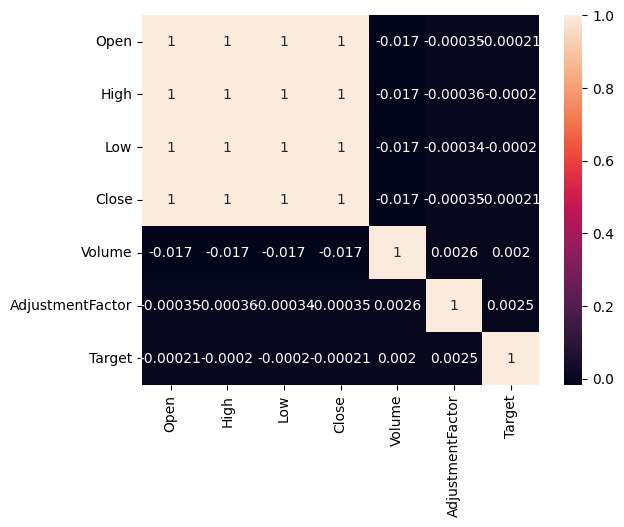

In [13]:
sns.heatmap(stock_prices2021.corr(), annot=True)
plt.show()

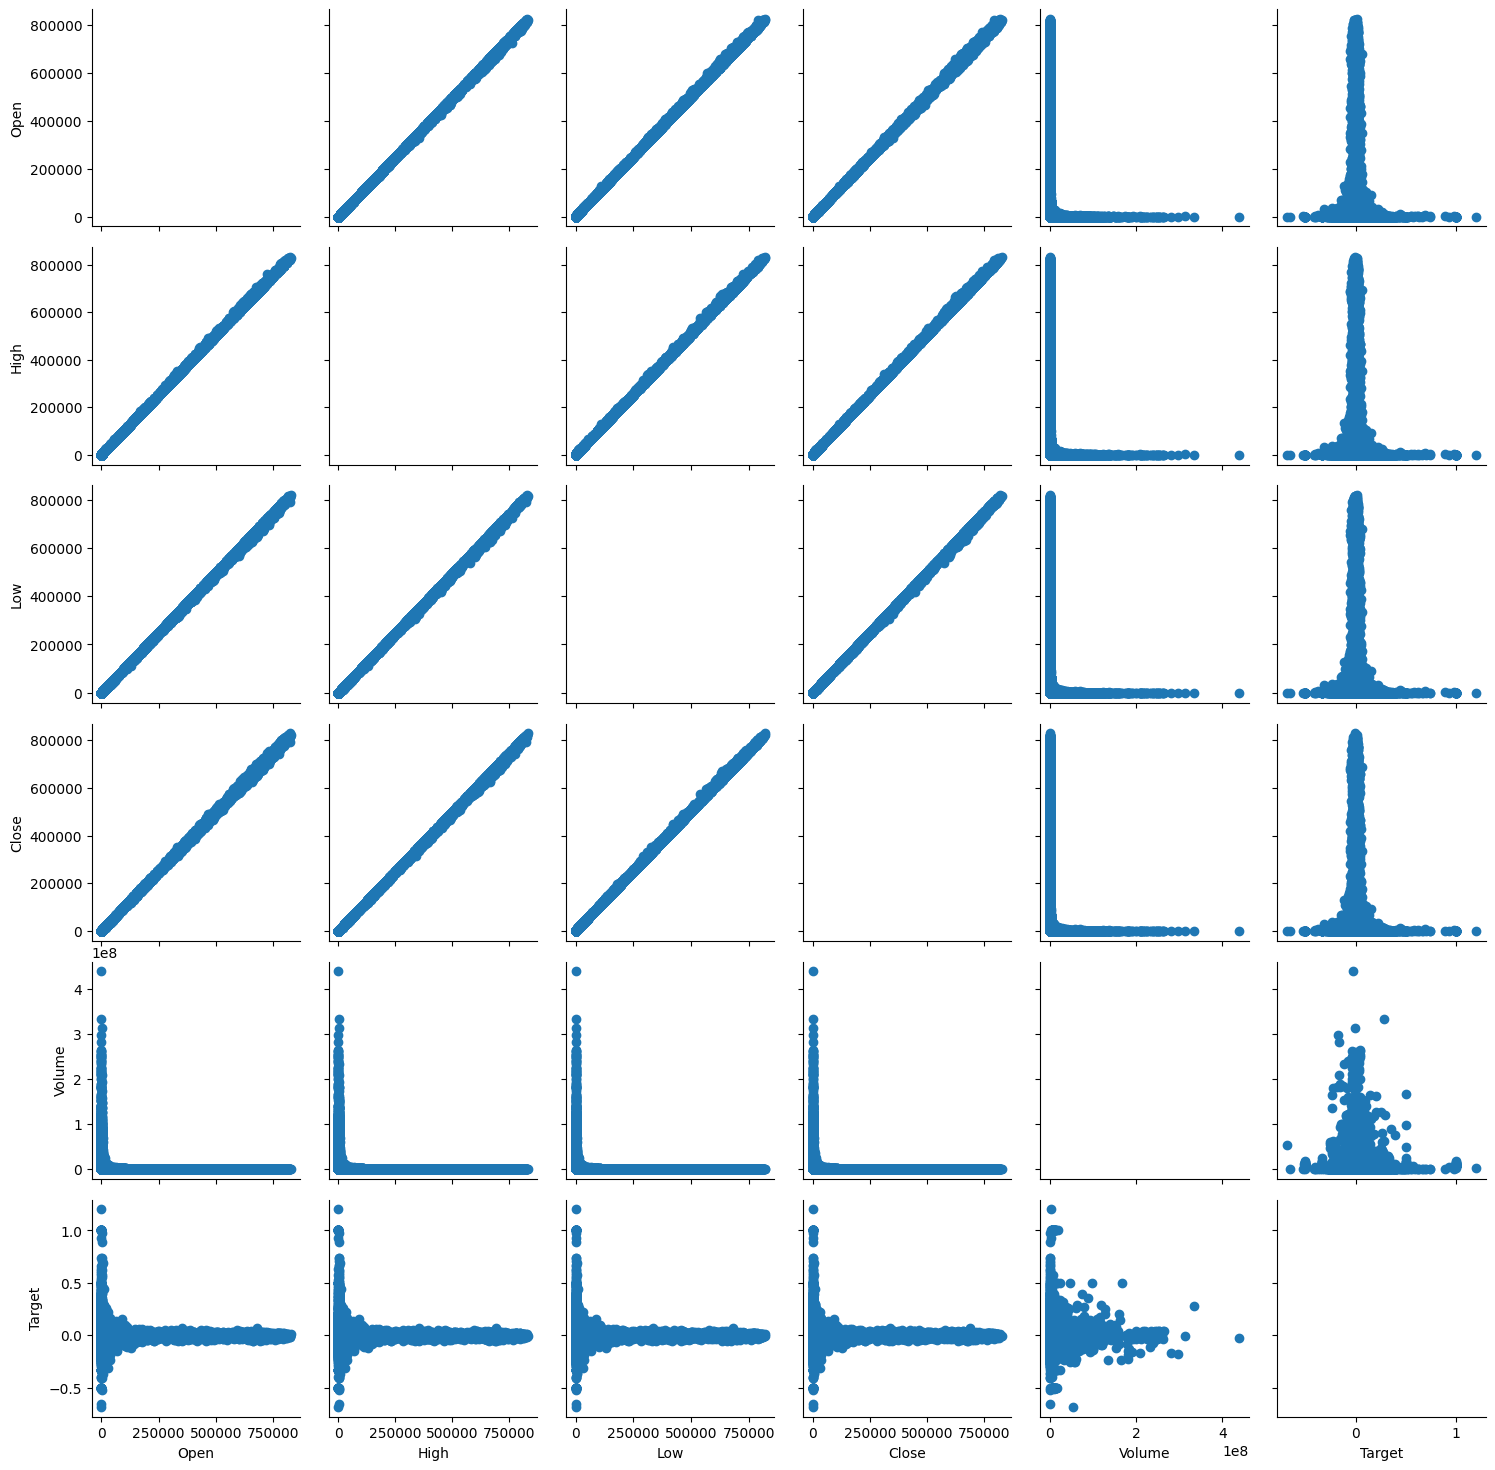

In [16]:
g = sns.PairGrid(data = stock_prices2021, vars = ['Open', 'High', 'Low','Close','Volume','Target'])
g.map_offdiag(plt.scatter)

In [17]:
# choose features:open,high,low,close,volume
def featuring(data):
    #data['ExpectedDividend'] = data['ExpectedDividend'].fillna(0)
    #data["SupervisionFlag"] = data["SupervisionFlag"].astype(int)
    data['Target'] = data['Target'].fillna(0)
    
    cols = ['Open', 'High', 'Low', 'Close','Volume']
    data.loc[:,cols] = data.loc[:,cols].ffill()
    data.loc[:,cols] = data.loc[:,cols].bfill()

    
    
    data['Open'] = stats.zscore(data['Open'])
    data['High'] = stats.zscore(data['High'])
    data['Low'] = stats.zscore(data['Low'])
    data['Close'] = stats.zscore(data['Close'])
    data['Volume'] = stats.zscore(data['Volume'])
    
    data = data.drop(['RowId','AdjustmentFactor','ExpectedDividend','SupervisionFlag'], axis=1)
    
    return data

In [18]:
df=featuring(prices1)
df

,Date,SecuritiesCode,Open,High,Low,Close,Volume,Target
0,2017-01-04,1301,-0.089035,-0.089252,-0.088276,-0.088774,-0.129272,0.000730
1,2017-01-04,1332,-0.150313,-0.150384,-0.150109,-0.150198,0.709902,0.012324
2,2017-01-04,1333,-0.077267,-0.076487,-0.076577,-0.075533,-0.056670,0.006154
3,2017-01-04,1376,-0.123663,-0.123059,-0.123087,-0.122499,-0.135368,0.011053
4,2017-01-04,1377,-0.073872,-0.072559,-0.072867,-0.072138,-0.093062,0.003026
...,...,...,...,...,...,...,...,...
284578,2022-06-24,9980,-0.163242,-0.163430,-0.163064,-0.163241,-0.112107,-0.009009
284579,2022-06-24,9986,-0.113705,-0.112874,-0.113043,-0.112229,-0.137733,-0.007495
284580,2022-06-24,9995,-0.155009,-0.155210,-0.154760,-0.154980,-0.133942,0.004950
284581,2022-06-24,9996,-0.130142,-0.130605,-0.131049,-0.131242,-0.138279,0.000806


In [19]:
df_1=df.drop(['Target'],axis=1)
df_1

,Date,SecuritiesCode,Open,High,Low,Close,Volume
0,2017-01-04,1301,-0.089035,-0.089252,-0.088276,-0.088774,-0.129272
1,2017-01-04,1332,-0.150313,-0.150384,-0.150109,-0.150198,0.709902
2,2017-01-04,1333,-0.077267,-0.076487,-0.076577,-0.075533,-0.056670
3,2017-01-04,1376,-0.123663,-0.123059,-0.123087,-0.122499,-0.135368
4,2017-01-04,1377,-0.073872,-0.072559,-0.072867,-0.072138,-0.093062
...,...,...,...,...,...,...,...
284578,2022-06-24,9980,-0.163242,-0.163430,-0.163064,-0.163241,-0.112107
284579,2022-06-24,9986,-0.113705,-0.112874,-0.113043,-0.112229,-0.137733
284580,2022-06-24,9995,-0.155009,-0.155210,-0.154760,-0.154980,-0.133942
284581,2022-06-24,9996,-0.130142,-0.130605,-0.131049,-0.131242,-0.138279


## create models ##

In [24]:
features =['High','Low','Open','Close','Volume']
df_X=df[features]
df_Y=df['Target']
df_X

,High,Low,Open,Close,Volume
0,-0.089252,-0.088276,-0.089035,-0.088774,-0.129272
1,-0.150384,-0.150109,-0.150313,-0.150198,0.709902
2,-0.076487,-0.076577,-0.077267,-0.075533,-0.056670
3,-0.123059,-0.123087,-0.123663,-0.122499,-0.135368
4,-0.072559,-0.072867,-0.073872,-0.072138,-0.093062
...,...,...,...,...,...
284578,-0.163430,-0.163064,-0.163242,-0.163241,-0.112107
284579,-0.112874,-0.113043,-0.113705,-0.112229,-0.137733
284580,-0.155210,-0.154760,-0.155009,-0.154980,-0.133942
284581,-0.130605,-0.131049,-0.130142,-0.131242,-0.138279


In [25]:
df_Y

0         0.000730
1         0.012324
2         0.006154
3         0.011053
4         0.003026
            ...   
284578   -0.009009
284579   -0.007495
284580    0.004950
284581    0.000806
284582    0.012386
Name: Target, Length: 5271570, dtype: float64

In [26]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_X,df_Y, test_size=0.2, random_state=42)

In [27]:
 X_train.shape,X_test.shape

((4217256, 5), (1054314, 5))

## model 1 : Linear regression

In [28]:
from sklearn.linear_model import LinearRegression

# Create an instance of the LinearRegression class
model_reg = LinearRegression()

# Train the model on the training data
model_reg.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model_reg.predict(X_test)

# print the parameters
print(model_reg.coef_) 
print(model_reg.intercept_) 
print(model_reg.get_params())

[ 1.66040876e-02  1.30180326e-02  4.30541364e-04 -3.00888889e-02
 -5.26237688e-05]
0.00031187441304310516
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': 'deprecated', 'positive': False}


In [29]:
y_pred

array([0.00032916, 0.00032359, 0.00032306, ..., 0.00031736, 0.00034186,
       0.00288314])

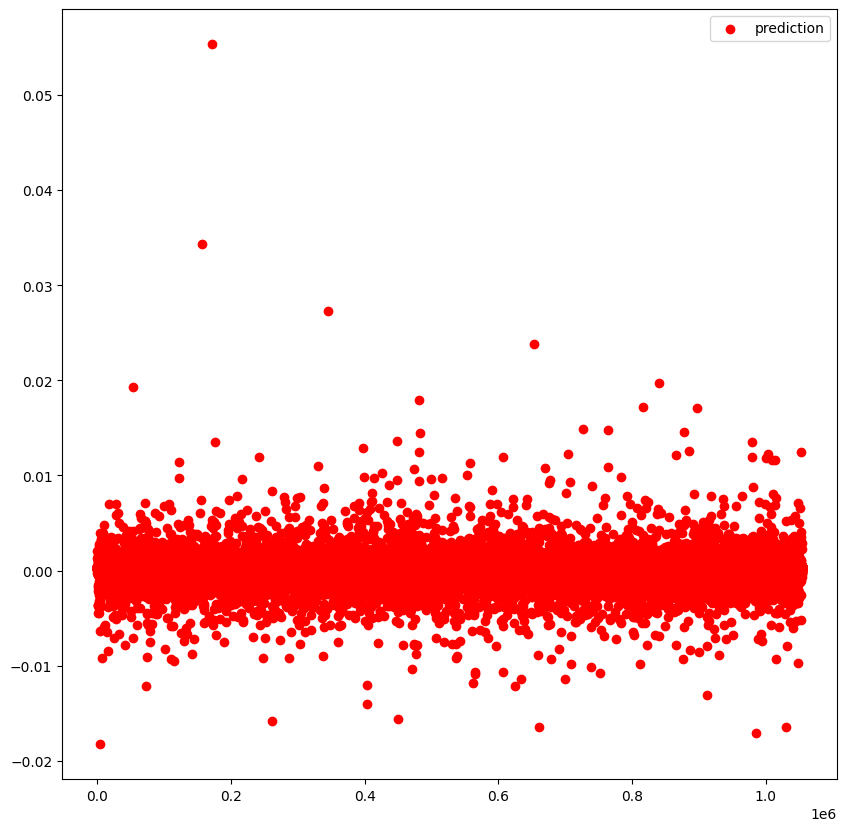

In [48]:
n=len(y_pred)
x=[i for i in range (n)]
plt.figure(figsize=(10,10))
plt.scatter(x,y_pred,label='prediction',color='r')
#plt.scatter(x,y_test,label='actual',color='y')
plt.legend()
plt.show()


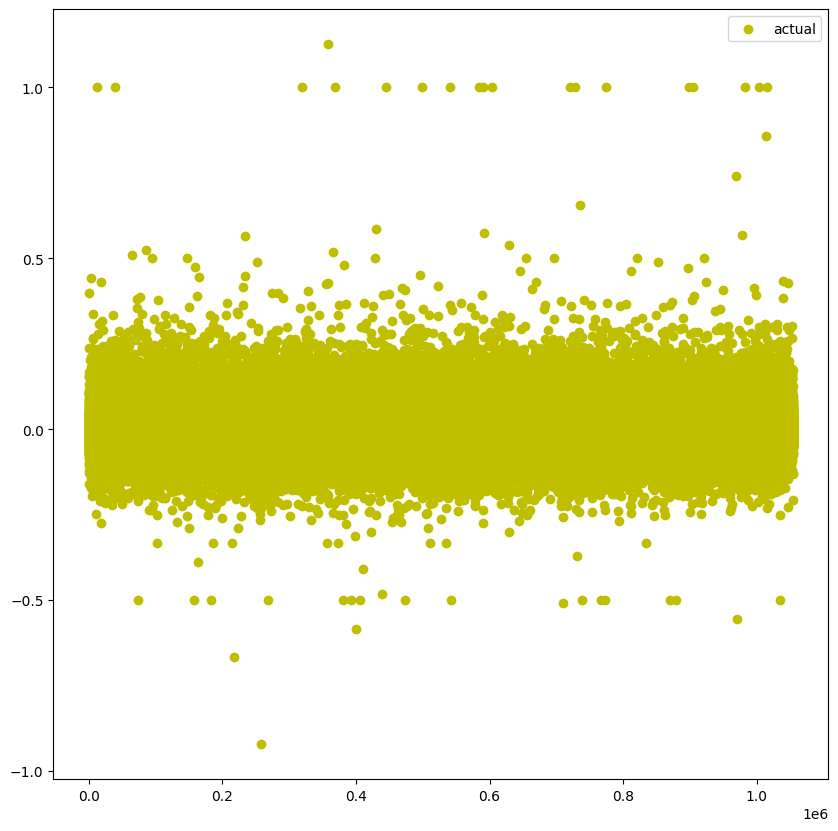

In [49]:
n=len(y_pred)
x=[i for i in range (n)]
plt.figure(figsize=(10,10))
#plt.scatter(x,y_pred,label='prediction',color='r')
plt.scatter(x,y_test,label='actual',color='y')
plt.legend()
plt.show()

In [30]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)
mse

0.0006810311802917301

In [31]:
import math
rmse=math.sqrt(mse)
rmse

0.026096574110249224

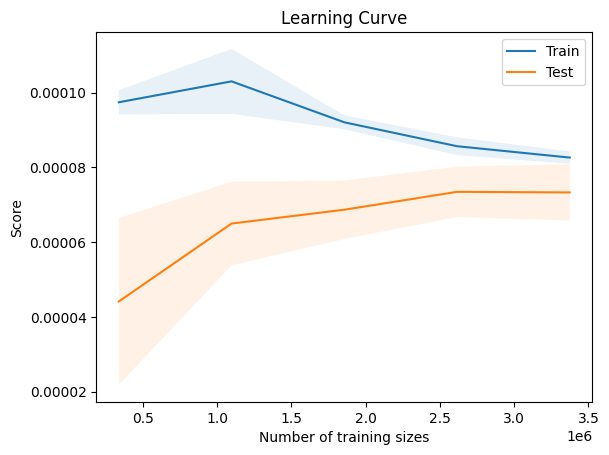

In [32]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Generate the learning curve
train_sizes, train_scores, test_scores = learning_curve(model_reg, X_train, y_train, cv=5)

# Calculate the mean and standard deviation of the training scores and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes, train_mean, label='Train')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, test_mean, label='Test')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel('Number of training sizes')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend()
plt.show()

## Evaluate Function ##

In [ ]:
import numpy as np
import pandas as pd


def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio

In [35]:
def calc_spread_return_per_day(df, portfolio_size=200, toprank_weight_ratio=2):
    assert df['Rank'].min() == 0
    assert df['Rank'].max() == len(df['Rank']) - 1
    weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
    purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
    short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
    return purchase - short

def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size=200, toprank_weight_ratio=2):
    buf = df.groupby('Date').apply(calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio#, buf

def add_rank(df):
    df["Rank"] = df.groupby("Date")["Target"].rank(ascending=False, method="first") - 1 
    df["Rank"] = df["Rank"].astype("int")
    return df

def fill_nan_inf(df):
    df = df.fillna(0)
    df = df.replace([np.inf, -np.inf], 0)
    return df

def check_score(df,preds,Securities_filter=[]):
    tmp_preds=df[['Date','SecuritiesCode']].copy()
    tmp_preds['Target']=preds
    
    #Rank Filter. Calculate median for this date and assign this value to the list of Securities to filter.
    tmp_preds['target_mean']=tmp_preds.groupby("Date")["Target"].transform('median')
    tmp_preds.loc[tmp_preds['SecuritiesCode'].isin(Securities_filter),'Target']=tmp_preds['target_mean']
    
    tmp_preds = add_rank(tmp_preds)
    df['Rank']=tmp_preds['Rank']
    score=round(calc_spread_return_sharpe(df, portfolio_size= 200, toprank_weight_ratio= 2),5)
    score_mean=round(df.groupby('Date').apply(calc_spread_return_per_day, 200, 2).mean(),5)
    score_std=round(df.groupby('Date').apply(calc_spread_return_per_day, 200, 2).std(),5)
    print(f'Competition_Score:{score}, rank_score_mean:{score_mean}, rank_score_std:{score_std}')
    

In [40]:
n_split=int(df.shape[0]*0.2)
test=df[-n_split:]
test

,Date,SecuritiesCode,Open,High,Low,Close,Volume,Target
1884725,2020-12-08,1730,-0.150850,-0.151002,-0.151022,-0.150736,-0.137521,0.001821
1884726,2020-12-08,1736,-0.104426,-0.104823,-0.103684,-0.104109,-0.138673,-0.004525
1884727,2020-12-08,1737,-0.137809,-0.137647,-0.137469,-0.137664,-0.135914,0.011940
1884728,2020-12-08,1739,-0.147993,-0.148028,-0.147684,-0.147822,-0.134610,-0.013889
1884729,2020-12-08,1743,-0.147993,-0.148028,-0.147684,-0.147822,-0.138795,0.028777
...,...,...,...,...,...,...,...,...
284578,2022-06-24,9980,-0.163242,-0.163430,-0.163064,-0.163241,-0.112107,-0.009009
284579,2022-06-24,9986,-0.113705,-0.112874,-0.113043,-0.112229,-0.137733,-0.007495
284580,2022-06-24,9995,-0.155009,-0.155210,-0.154760,-0.154980,-0.133942,0.004950
284581,2022-06-24,9996,-0.130142,-0.130605,-0.131049,-0.131242,-0.138279,0.000806


In [41]:
check_score(test,y_pred)

Competition_Score:0.08333, rank_score_mean:0.04378, rank_score_std:0.52534
